In [17]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore')
# Для отрисовки дерева
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [18]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

### Интерпретация моделей

В мире анализа данных очень важным качеством модели является её интерпретируемость. Многие бизнес решения склоняются в пользу более простых моделей с меньшим качеством, ввиду лучшей интерпретируемости таких моделей. Если модель не поддаётся интерпретации, то её с меньшей охотой внедряют в продакшн, ведь нельзя проанализировать, на каких объектах эта модель поведёт анамально и почему она так себя повела. 

Однако и для сложных нелинейных моделей (деревья решений, нейронные сети и т.д.) существуют способы интерпретации и анализа их работы. 

Начнём с простейших линейных моделей - линейная и логистическая регрессии.

<font color='red'>Линейная регрессия</font> это модель вида: $y = w_{0} + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + \dots + w_{d} \cdot x_{d}, \ y \in \mathbb{R}$. Линейной она называется потому, что эта модель <b><i>линейная по параметрам ($w_{k}$)</i></b>, то есть модель $y = w_{0} + w_{1} \cdot x_{1}^2 + w_{2} \cdot x_{1}^3$ тоже будет называться линейной регрессией.

Её любят статистики за простую интерпретируемость. 

Рассмотрим на примере.

Пусть есть модель зависимости стоимости квартиры (млн. Руб.) от различных характеристик квартиры: 

$$price = 3 + 2 \cdot n\_rooms + 0.3 \cdot metro\_dist - 0.1 \cdot floor$$

Тогда коэффициент при n\_rooms можно проинтерпретировать так: 

При прочих равных условиях (а именно, если мы будем рассматривать множество квартир, отличающихся только количеством комнат), при увеличении числа комнат в квартире на 1 общая цена квартиры растёт <b>в среднем</b> на 2 млн. руб. 

При floor: При прочих равных условиях, при этажа на котором располагается квартира на 1 общая цена квартиры падает <b>в среднем</b> на 100 тыс. руб. (0.1 млн. руб.) 

Рассмотрим вариации этой модели и как будет меняться интерпретация в зависимости от вида линейной регрессии:

1) $y = w \cdot \ln x$

При прочих равных условиях при увеличении переменной x на $\boxed{1 \%}$ переменная y меняется на $\boxed{w \cdot 100 \ единиц}$

2) $\ln y = w \cdot x$

При прочих равных условиях при увеличении переменной x на $\boxed{1 \ единицу}$ переменная y меняется на $\boxed{(e^{w} - 1) \cdot 100\%}$

3) $\ln y = w \cdot \ln x$

При прочих равных условиях при увеличении переменной x на $\boxed{1\%}$ переменная y меняется на $\boxed{w\%}$

Однако с линейной регрессией нужно умень оценивать адекватность модели для того, чтобы можно было проводить такую интерпретацию коэффициентов. В случае наличиня [мультиколлинеарности](https://ru.wikipedia.org/wiki/Мультиколлинеарность) в модели оценки теряют интерпретируемость.

Рассмотрим пример.

Пусть была оценена линейная регрессия со следующими параметрами

$$y = 3 + 5 \cdot x  - 3 \cdot w + 15 \cdot z$$

Но пусть так же известно, что переменные x и w связаны соотношением: $z = 2 \cdot x - 7 \cdot w \Rightarrow z - 2 \cdot x + 7 \cdot w = 0$

Тогда: $y = 3 + 5 \cdot x  - 3 \cdot w + 15 \cdot z + 0 = 3 + 5 \cdot x  - 3 \cdot w + 15 \cdot z + (z - 2 \cdot x + 7 \cdot w) = 3 + 3 \cdot x + 4 \cdot w + 16 \cdot z$

Получаем совсем другие коэффициенты перед признаками, однако само уравнение по прежнему точно так же описывает y, как и изначальное уравнение.

<font color='red'>Логистическая регрессия</font> это модель вида: $\mathbb{P}(y = 1 | x_{1}, \dots, x_{n}) = \sigma(w_{0} + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + \dots + w_{d} \cdot x_{d}), \ y \in \{ 0, 1 \}, \ \sigma(z) = \frac{1}{1 + e^{-z}}$. Это тоже считается линейной моделью, так как если мы сделаем преобразование $\mathbb{P}(y = 1 | x_{1}, \dots, x_{n}) \to \ln\left(\frac{\mathbb{P}(y = 1 | x_{1}, \dots, x_{n})}{1-\mathbb{P}(y = 1 | x_{1}, \dots, x_{n})}\right)$, то модель будет иметь вид обычной линейной регрессии: $\ln\left(\frac{\mathbb{P}(y = 1 | x_{1}, \dots, x_{n})}{1-\mathbb{P}(y = 1 | x_{1}, \dots, x_{n})}\right) = w_{0} + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + \dots + w_{d} \cdot x_{d}$

Заметим, что в линейной регрессии мы интерпретировали коэффициенты так: как поменяется y, в результате изменения x. Иными словами, мы хотели понять: $\Delta x \to \Delta y$. Вспомним, что $\Delta y \approx y^{\prime} \cdot \Delta x$. Тогда в логистической регрессии можно интерпретировать коэффициент $w_{k}$ так: $\Delta P(y = 1) = \sigma(w_{0} + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + \dots + w_{d} \cdot x_{d})^{\prime}_{x_{k}} \cdot w_{k} \cdot \Delta x$. Для логистической функции известно, что $\sigma(z)' = \sigma(z) \cdot (1 - \sigma(z))$.

Окончательно имеем: При увеличении $x_{k}$ на 1 единицу $\mathbb{P}(y = 1 | x_{1}, \dots, x_{n})$ изменяется на $\sigma(w_{0} + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + \dots + w_{d} \cdot x_{d}) \cdot (1 - \sigma(w_{0} + w_{1} \cdot x_{1} + w_{2} \cdot x_{2} + \dots + w_{d} \cdot x_{d})) \cdot w_{k}$ единиц.

Рассмотрим пример.

600 водителей, выбранных случайным образом, попросили
пройти специальный тест на вождение автомобилем. Для каждого водителя были собраны следующие данные: Pass — фиктивная переменная,
равная единице, если водитель сдал тест, Male — фиктивная переменная,
равная единице, если водитель мужчина, и равная 0, если водитель женщина, Experience — опыт вождения автомобилем (в годах). Оценённая модель логистической регрессии имеет вид:

$$\mathbb{P}(y = 1 | Expeience, Male) = \sigma(0.8 + 0.08 \cdot Experience - 0.17 \cdot Male - 0.04 \cdot Male \cdot Experience)$$

Проинтерпретируем как меняется выроятность для мужчины сдать тест при увеличении стажа на 1 год (если его текущий стаж равен 5 годам). Для мужчины модель принимает вид: 

$$\mathbb{P}(y = 1 | Expeience, Male) = \sigma(0.63 + 0.04 \cdot Experience)$$

Получаем: При прочих равных условиях, при увеличении опыта вождения на 1 год вероятность сдать тест увеличивается на $\sigma(0.63 + 0.04 \cdot Experience) \cdot (1 - \sigma(0.63 + 0.04 \cdot Experience)) \cdot 0.04 = \sigma(0.63 + 0.04 \cdot 5) \cdot (1 - \sigma(0.63 + 0.04 \cdot 5)) \cdot 0.04 \approx 0.008 \ $ (примерно 1%)


In [19]:
from sklearn.datasets import load_boston

In [20]:
dat = pd.DataFrame(np.c_[load_boston()['data'], load_boston()['target']], 
                   columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'])
dat.columns = [col.lower() for col in dat.columns]
dat.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per $10,000

PTRATIO - pupil-teacher ratio by town

B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT - % lower status of the population

MEDV - Median value of owner-occupied homes in $1000's

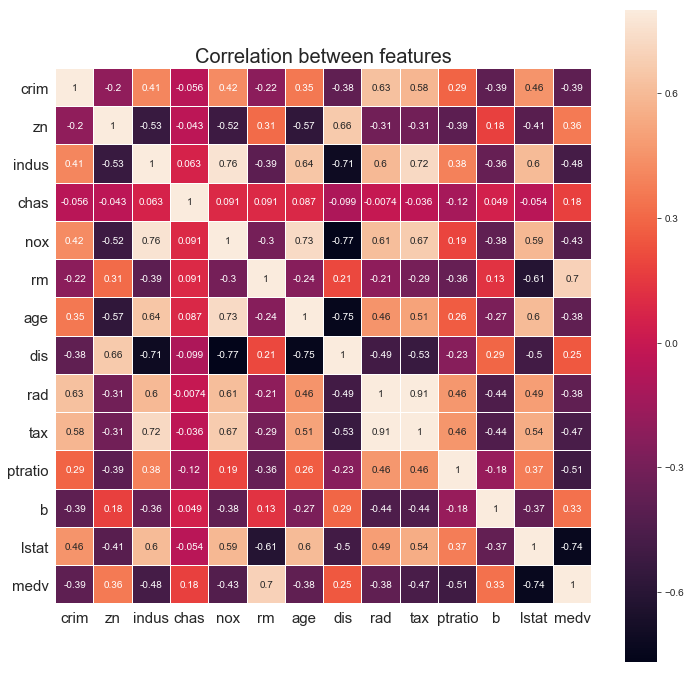

In [86]:
plt.figure(figsize=(12, 12))
sns.heatmap(dat.corr(), vmax=.8, linewidths=0.01,
            square=True, annot=True, cmap=None, linecolor="white")
plt.title('Correlation between features', fontsize=20);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15, rotation=0);

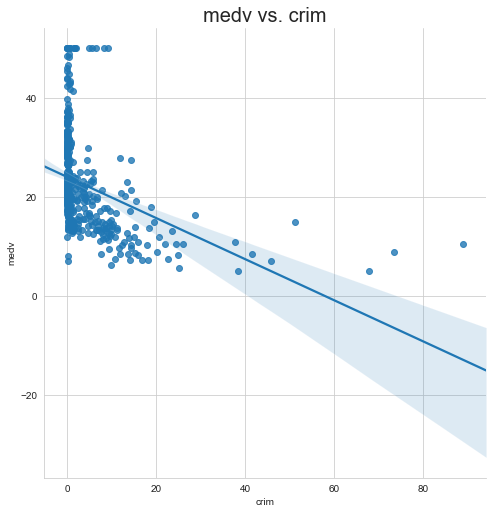

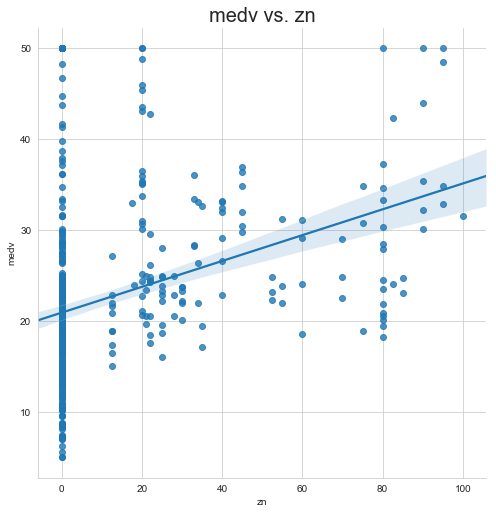

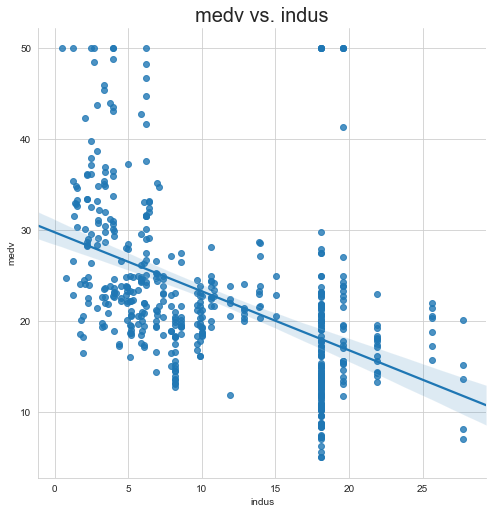

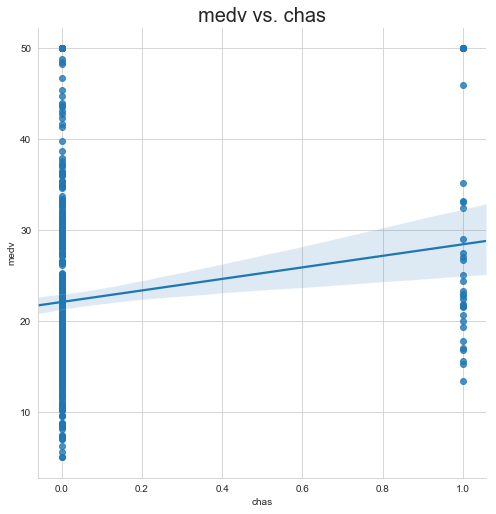

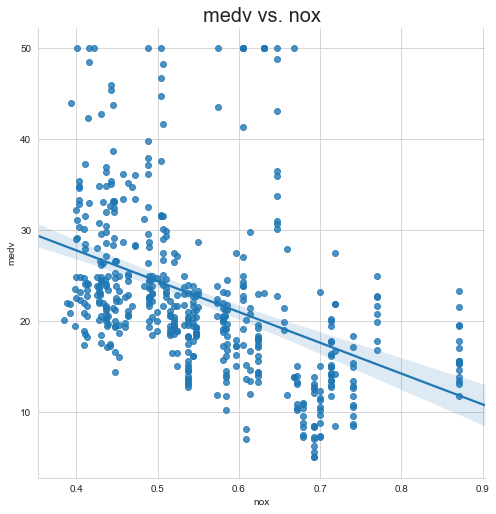

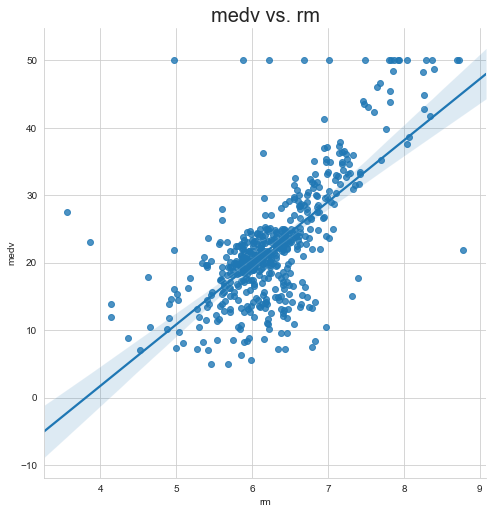

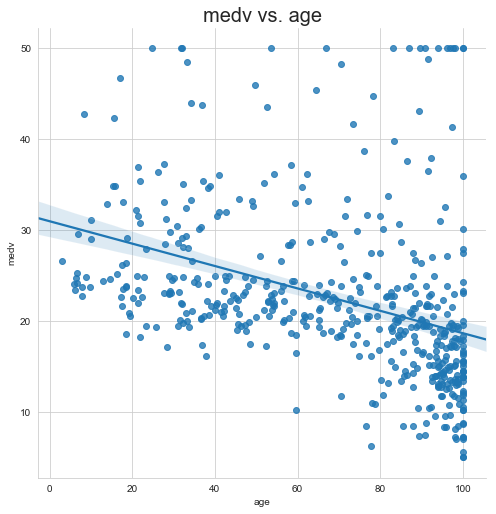

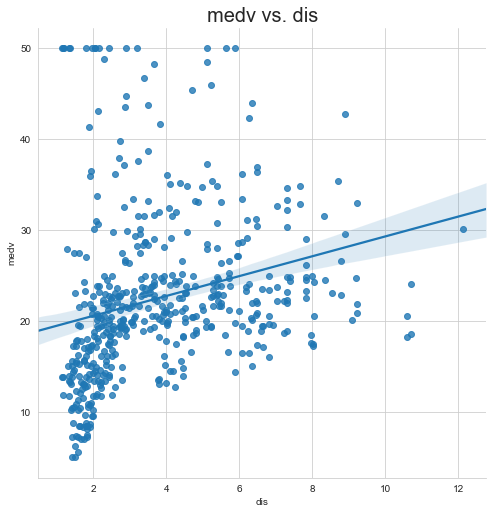

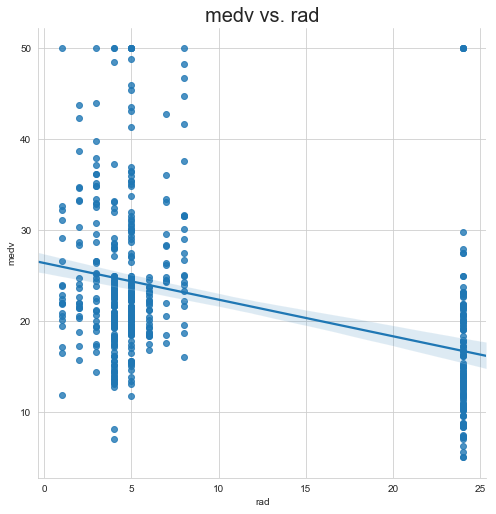

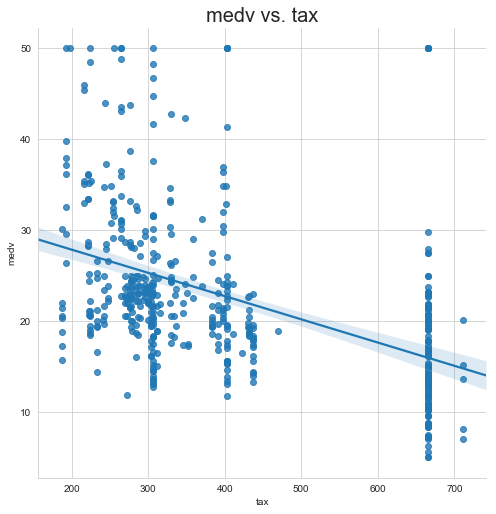

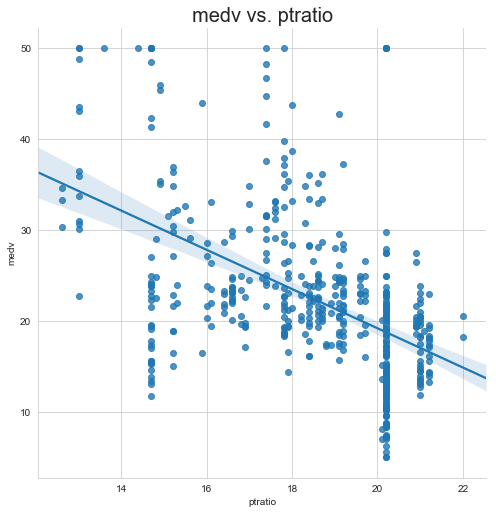

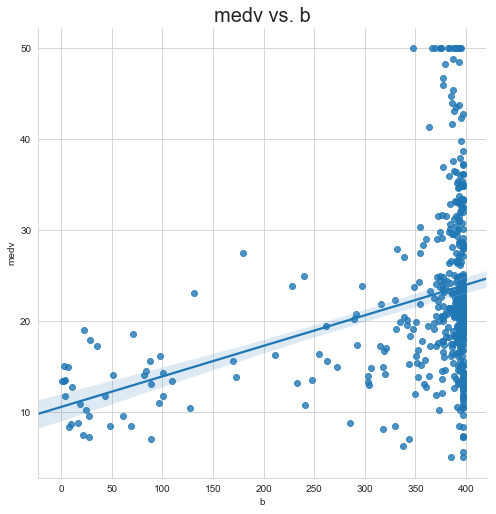

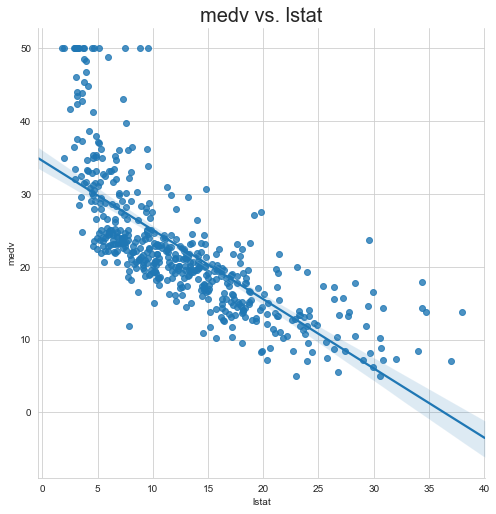

In [78]:
for col in dat.columns[:-1]:
    sns.lmplot(x=col, y='medv', data=dat, height=7, aspect=1, );
    plt.title('medv vs. ' + col, fontsize=20);

Постоим линейную регрессию медианной цены на остальные факторы (исключив переменные, которые сильно связаны друг с другом)

In [79]:
import statsmodels.formula.api as smf

In [85]:
model = smf.ols('medv ~ crim + zn + chas + rm + age + dis + ptratio + b', data=dat).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     117.0
Date:                Tue, 09 Jul 2019   Prob (F-statistic):          3.68e-109
Time:                        14:18:48   Log-Likelihood:                -1572.3
No. Observations:                 506   AIC:                             3163.
Df Residuals:                     497   BIC:                             3201.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3031      4.201     -0.548      0.5

Коэффициенты с помощью sklearn

In [5]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(dat[['crim', 'zn', 'chas', 'rm', 'age', 'dis', 'ptratio', 'b']], dat.medv)
print('Const: {}'.format(lr.intercept_))
for n, coef in enumerate(['crim', 'zn', 'chas', 'rm', 'age', 'dis', 'ptratio', 'b']):
    print('{}: {}'.format(coef, np.round(lr.coef_[n], decimals=4)))

Const: -2.303112617466205
crim: -0.1416
zn: 0.0312
chas: 3.2172
rm: 6.9473
age: -0.0769
dis: -0.9727
ptratio: -0.8519
b: 0.0162


Для некоторых нелинейных моделей есть тоже интуитивно понятная интерпретация работы, например для решающего дерева.

In [21]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor(max_depth=4) # чтобы не громоздко отрисовалось дерево
tree_model.fit(dat[['crim', 'zn', 'chas', 'rm', 'age', 'dis', 'ptratio', 'b']], dat.medv)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Визуализируем получившееся дерево

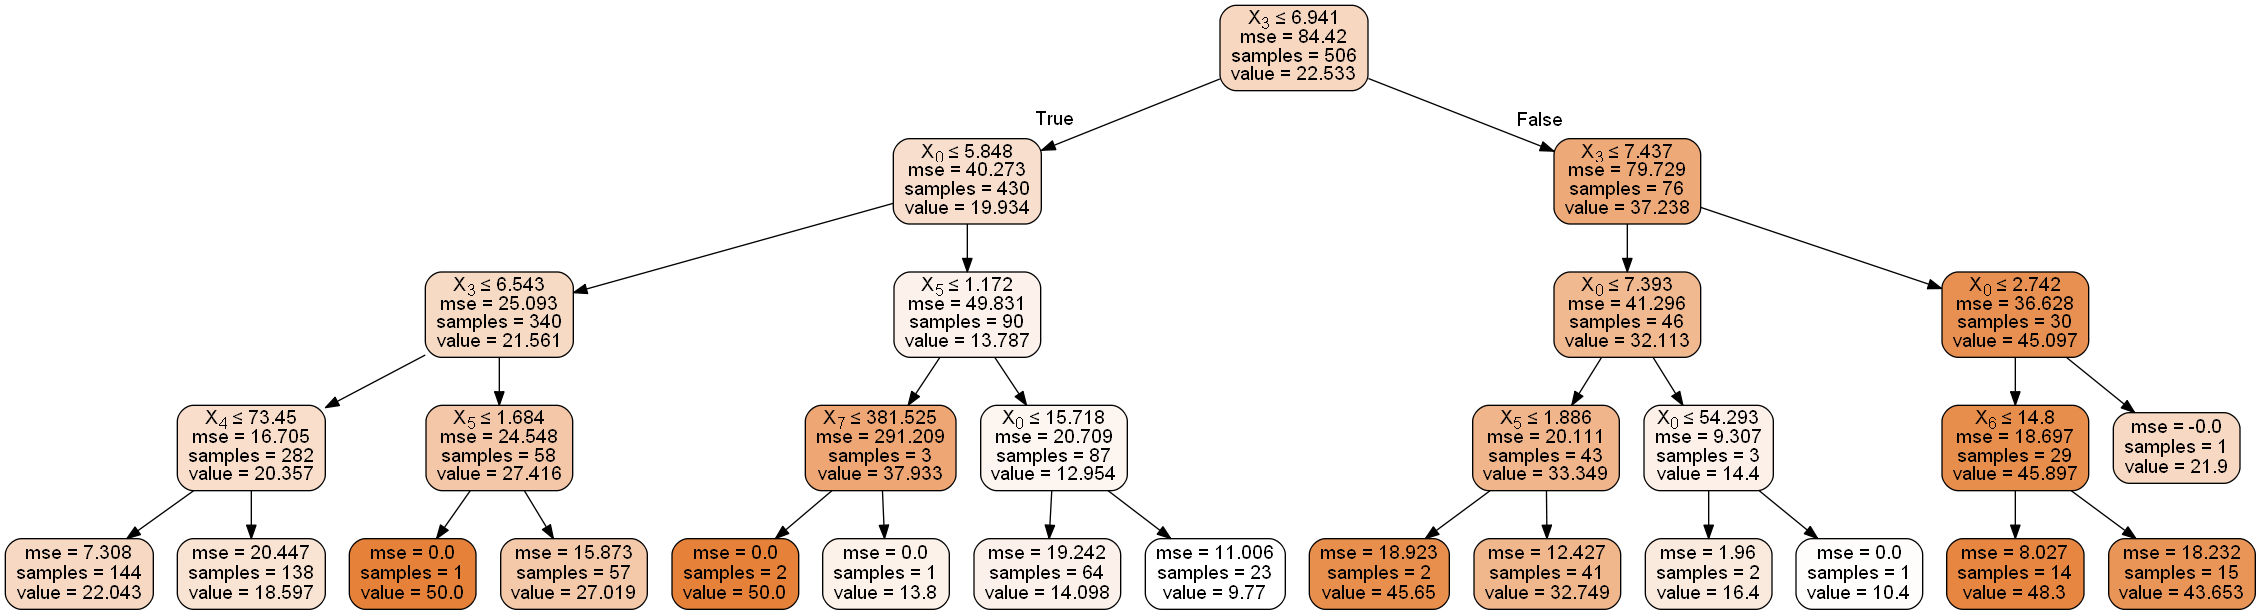

In [22]:
dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())